In [5]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

In [6]:
#pip install pillow

In [7]:
!python -m spacy download en_core_web_lg -q

2022-08-28 14:53:45.521364: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 9.1 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
# NLTK Downloads

nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [10]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


### Data Wrangling Utility Functions

In [11]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    #data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count


### Knowledge Context Graph Functions

In [12]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

### Entity Extraction Functions

In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

### Visualization Utility Functions

In [14]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Loading the Class Corpus

In [15]:
data = pd.read_csv('https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/ClassCorpus_Final_v5_20220717.csv')
corpus_df = get_corpus_df(data)

In [16]:
data.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Descriptor
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Negative,Taxi,Action_Taxi_N_160
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi,Action_Taxi_P_161
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi,Action_Taxi_N_162
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Negative,Taxi,Action_Taxi_N_163
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Negative,Taxi,Action_Taxi_N_164


In [17]:
corpus_df.head()

,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Descriptor,Doc_ID
Doc_ID,,,,,,,,,
40,KCM_Doc1_AngelHasFallen,Boredom sets in long before the start of Angel...,KCM_Doc1_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_40,40
41,KCM_Doc2_AngelHasFallen,\nWho ARE all these people?\n\nThat was what...,KCM_Doc2_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_41,41
42,KCM_Doc3_AngelHasFallen,Ric Roman Waughs Angel Has Fallen sees U.S. S...,KCM_Doc3_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_42,42
43,KCM_Doc4_AngelHasFallen,There is a certain mindless pleasure in the Fa...,KCM_Doc4_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_43,43
44,KCM_Doc5_AngelHasFallen,"No, you dont need to have seen Olympus Has F...",KCM_Doc5_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_44,44


### Exploratory Data Analysis

In [18]:
# Tokenize sentences for following analysis

corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)

In [19]:
corpus_df.head(4).T

Doc_ID,40,41,42,43
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43
Doc_ID,40,41,42,43
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...


### Tokenize Words

In [20]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fallen, sta...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waughs, angel, fallen, secret, se...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

### Reassemble Leminized Words

In [21]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [22]:
corpus_df['lemmas_joined'].head()

Doc_ID
40    boredom set long start angel fallen start jour...
41    people mutter enter screening angel fallen loc...
42    ric roman waughs angel fallen secret service a...
43    certain mindless pleasure fallen movie watch g...
44    dont need olympus fallen andor london fallen u...
Name: lemmas_joined, dtype: object

In [23]:
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...


### Vocabulary Data Wrangling

In [24]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.9)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 12203
Curated Vocabulary size: 2912


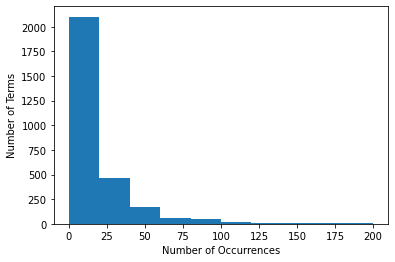

In [25]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [26]:
# Re-tokenize words, recreate joined documents

corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
40    [set, long, start, angel, fallen, start, journ...
41    [people, enter, angel, fallen, local, cinema, ...
42    [ric, roman, angel, fallen, secret, service, a...
43    [certain, pleasure, fallen, movie, watch, gera...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

In [27]:
corpus_df.head()

,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Descriptor,Doc_ID,raw_sentences,lemmas,lemmas_joined
Doc_ID,,,,,,,,,,,,
40,KCM_Doc1_AngelHasFallen,Boredom sets in long before the start of Angel...,KCM_Doc1_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_40,40,[Boredom sets in long before the start of Ange...,"[set, long, start, angel, fallen, start, journ...",set long start angel fallen start journey movi...
41,KCM_Doc2_AngelHasFallen,\nWho ARE all these people?\n\nThat was what...,KCM_Doc2_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_41,41,[\nWho ARE all these people?\n\nThat was wha...,"[people, enter, angel, fallen, local, cinema, ...",people enter angel fallen local cinema sunny l...
42,KCM_Doc3_AngelHasFallen,Ric Roman Waughs Angel Has Fallen sees U.S. S...,KCM_Doc3_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_42,42,[Ric Roman Waughs Angel Has Fallen sees U.S. ...,"[ric, roman, angel, fallen, secret, service, a...",ric roman angel fallen secret service agent mi...
43,KCM_Doc4_AngelHasFallen,There is a certain mindless pleasure in the Fa...,KCM_Doc4_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_43,43,[There is a certain mindless pleasure in the F...,"[certain, pleasure, fallen, movie, watch, gera...",certain pleasure fallen movie watch gerard but...
44,KCM_Doc5_AngelHasFallen,"No, you dont need to have seen Olympus Has F...",KCM_Doc5_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,Action_Angel Has Fallen_N_44,44,"[No, you dont need to have seen Olympus Has ...","[dont, need, olympus, fallen, andor, london, f...",dont need olympus fallen andor london fallen u...


### Get Lemmatized and Filtered Sentences

In [28]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [29]:
corpus_df.head().T

Doc_ID,40,41,42,43,44
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...,"[No, you dont need to have seen Olympus Has ..."


In [30]:
# Subset the dataset for "Inception" Documents

movie_df = corpus_df[corpus_df['Movie Title'] == 'Inception'].copy()
movie_df.head(3).T

Doc_ID,85,86,87
DSI_Title,MGB_Doc6_Inception,MGB_Doc7_Inception,MGB_Doc8_Inception
Text,Inception makes the average moviegoer feel sma...,"You have this basic idea and the story, they a...",Unless you call this movie a masterpiece. Then...
Submission File Name,MGB_Doc6_Inception,MGB_Doc7_Inception,MGB_Doc8_Inception
Student Name,MGB,MGB,MGB
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Inception,Inception,Inception
Descriptor,Action_Inception_N_85,Action_Inception_N_86,Action_Inception_N_87
Doc_ID,85,86,87
raw_sentences,[Inception makes the average moviegoer feel sm...,"[You have this basic idea and the story, they ...","[Unless you call this movie a masterpiece., Th..."


In [31]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'DiCaprio has reached such super-stardom that can only be compared with Stallone,Schwarzenegger and Will Smith.'

In [32]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 514/514 [00:05<00:00, 101.57it/s]


In [33]:
entity_pairs

[['zero  fans', 'zero  that'],
 ['I', 'it'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['such  that', 'only  Stallone'],
 ['only  who', 'film'],
 ['Shutter Island Inceptions trailer', 'only  LEONARDO.DICAPRIO'],
 ['star  I', '-'],
 ['ON mix', 'actors'],
 ['though  it', 'all  Mal'],
 ['that', 'main  characters'],
 ['', ''],
 ['own fathers idea', 'fathers company'],
 ['HOW  we', 'HOW  PG'],
 ['', 'new  concept'],
 ['', ''],
 ['it', 'mail man'],
 ['human window that', 'bad Cotilliards Mal'],
 ['it', 'worthy  Oscarnomination'],
 ['Mal', ''],
 ['One  scene', 'especially  ledge'],
 ['who', ''],
 ['', 'good  actors'],
 ['', ''],
 ['characters', 'personalities'],
 ['you', 'What'],
 ['that', 'moment'],
 ['', ''],
 ['screenplay', 'mans potential'],
 ['Inception', 'twice  talent'],
 ['sophisticated alá Red Eye', 'blank  page'],
 ['', ''],
 ['complex', 'attention'],
 ['fast  you', 'ride'],
 ['you', ''],
 ['you', 'what'],
 ['same  mind', 'philosophical  metaphors'],
 ['deep  depth', 'deep  throat'],
 ['fil

### Create DataFrame (Source, Target, Edge)

In [34]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [35]:
# Lower case 

kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

In [36]:
# Filter out empties

kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [81]:
kg_df.head().T

,0,1,5,6,7
source,zero fans,i,such that,only who,shutter island inceptions trailer
target,zero that,it,only stallone,film,only leonardo.dicaprio
edge,makes,get,reached such,meaning,mentions


In [79]:
len(corpus_text_sentences)

514

In [80]:
kg_df.shape

(369, 3)

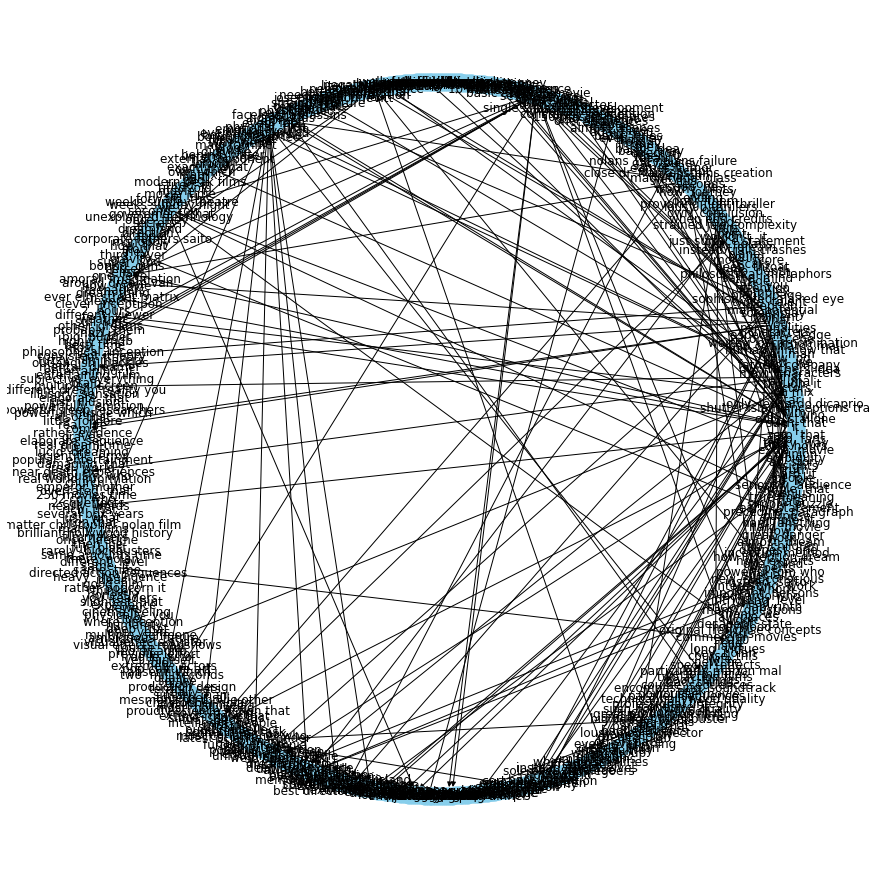

In [40]:
plot_graph(kg_df, use_circular=True)

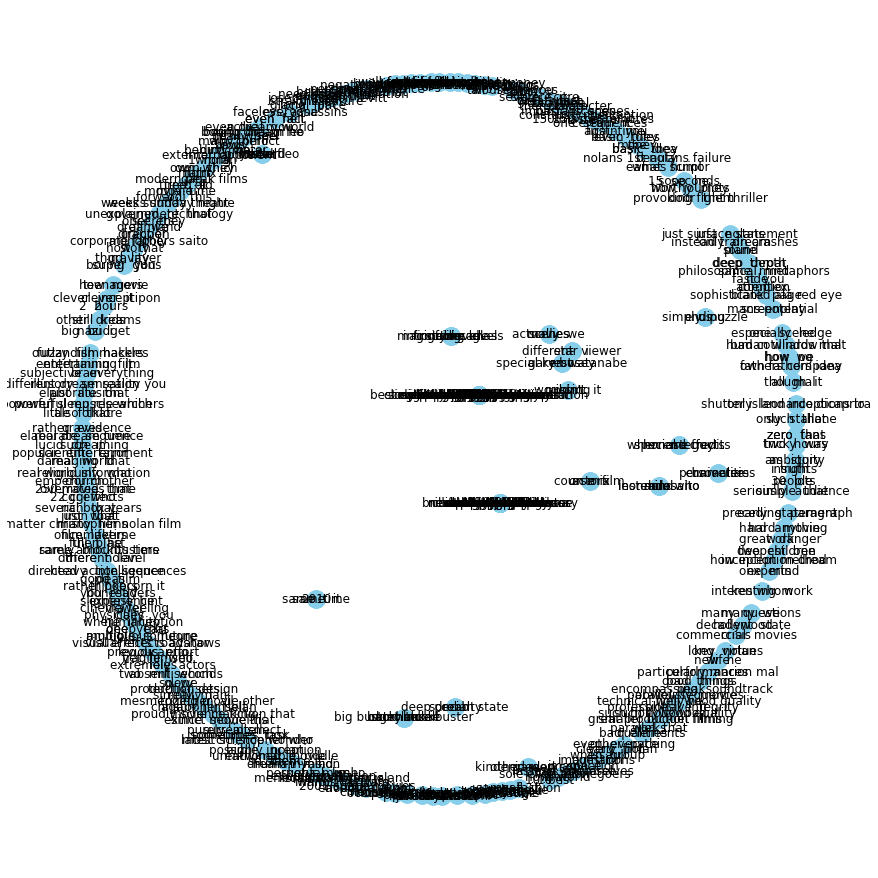

In [41]:
plot_graph(kg_df, use_circular=False)

### Recurrent Neural Network (RNN) Model Development

In [42]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...,"[No, you dont need to have seen Olympus Has ..."


In [43]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

### Process Dataset for Model Development

In [44]:
data = datafull[['Text','Genre of Movie']].copy()

In [45]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [46]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

### Create Datasets for Model Development

In [47]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

### Convert DataFrame to TensorFlow DataSet

In [48]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

### Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [49]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

### Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [50]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


### Create the Text Encoder

In [52]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [53]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [54]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', '’', 'i', 'movie', 'one', 'like',
       'time', 'it', 'make', 'nt', 'get', 'character', 'even', 'but', '”',
       '“'], dtype='<U19')

In [83]:
vocab[-20:]

array(['underplays', 'underlined', 'underdeveloped', 'undercurrent',
       'undeniable', 'uncover', 'unconventional', 'unconscious',
       'uncomfortably', 'uncle', 'unbeknownst', 'unashamedly',
       'unapologetic', 'unanswered', 'unabomber', 'unabashedly',
       'twilight', 'twang', 'tutu', 'turf'], dtype='<U19')

### Example of Encoded Words

In [56]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  174,    1,  830, 2998,    1,  128,  128])

In [84]:
len(encoder.get_vocabulary())

5000

In [58]:
encoder(data['Text'][0])

<tf.Tensor: shape=(507,), dtype=int64, numpy=
array([   1,   54,   81,  112,  434,  225,  323,    6,  112, 2052,    7,
       2937,   43, 2493,   60, 2134,  215,   60,  656,    9, 2103, 2630,
       4683,    1,  218,    1,    1, 3201,    1,    6,  665,    1, 3069,
        376, 1594,    1,  634,    6,   71,   60,  835, 3789,    9,   66,
         24,    7,    1,    1, 4408,  119,   71, 1325,  119,  213,  119,
          1,   11,  597,    8,  456, 1037, 3281,  104,    1,   93, 4021,
       1667,   91,   41, 1188,  237,  434,  225,  323,  625,  532,   35,
         41, 1188,   29,  339,    7,   82, 1193,  615,   41, 1339,  262,
         84, 2470,   29, 1253,  464,  403,    1,  281,  363,   35,  283,
       1667, 1537,  160,  597,  581, 2493, 2523,  104,   56,  191,  581,
        810,  725,   88, 3001, 3251,  370,  969,   64,  466,  886, 1352,
       3329,    1,  273,  491,  283,  213,    6,    1, 1352,    1, 4622,
         34,   40, 2406,    1, 1118, 3948,  327, 1161, 2129, 1892,    6,
     

In [59]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'My hope high \xe2\x80\x9c Dirty Grandpa , \xe2\x80\x9d simply mere existence made practical sense . A movie starring Robert De Niro Zac Efron \xe2\x80\x99 sound like real movie . It sound like fake movie \xe2\x80\x99 see clip film \xe2\x80\x99 mocking stupidity Hollywood . For intent purpose , \xe2\x80\x9c Dirty Grandpa \xe2\x80\x9d exist form one fake trailer open \xe2\x80\x9c Tropic Thunder . \xe2\x80\x9d And yet , . All 102 minute . Before watching , mind raced stupid possibility . How many Viagra joke would ? Would somebody ask De Niro Viagra induced boner De Niro respond , \xe2\x80\x9c Are talking ? \xe2\x80\x9d shortly one grip run onto set give high five ? Would scene dog win farting contest fart hard launch inside bare , gaping as competitor : cameo Harvey Keitel ( , \xe2\x80\x99 implied , accidentally overdosed Viagra ) ? Unfortunately , moment \xe2\x80\x93 outside Pinterest page and/or dream board . But luckily , got equally stupid . Maybe even little . As may alre

### Build RNN Sequential Model

### Genre classification

In [60]:
# Model 1

num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [61]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [62]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 98s 2s/step - loss: 1.3895 - accuracy: 0.2453 - val_loss: 1.3844 - val_accuracy: 0.3333
Epoch 2/200
53/53 [==============================] - 73s 1s/step - loss: 1.2320 - accuracy: 0.5157 - val_loss: 1.2666 - val_accuracy: 0.4444
Epoch 3/200
53/53 [==============================] - 75s 1s/step - loss: 0.5329 - accuracy: 0.7987 - val_loss: 1.2690 - val_accuracy: 0.6667
Epoch 4/200
53/53 [==============================] - 75s 1s/step - loss: 0.1506 - accuracy: 0.9560 - val_loss: 0.5833 - val_accuracy: 0.7778
Epoch 5/200
53/53 [==============================] - 76s 1s/step - loss: 0.0777 - accuracy: 0.9686 - val_loss: 1.5420 - val_accuracy: 0.5556
Epoch 6/200
53/53 [==============================] - 75s 1s/step - loss: 0.0515 - accuracy: 0.9874 - val_loss: 1.2106 - val_accuracy: 0.7778
CPU times: user 14min 45s, sys: 4.79 s, total: 14min 50s
Wall time: 8min 5s


### Model Performance Test Accuracy

In [88]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 183ms/step - loss: 1.6218 - accuracy: 0.5000
Test Loss: 1.6218006610870361
Test Accuracy: 0.5


In [92]:
# Model 2

num_classes=4
model2=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [94]:
model2.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [95]:
%%time
history = model2.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 46s 707ms/step - loss: 1.3860 - accuracy: 0.2453 - val_loss: 1.3834 - val_accuracy: 0.1111
Epoch 2/200
53/53 [==============================] - 34s 638ms/step - loss: 1.2956 - accuracy: 0.5849 - val_loss: 1.1991 - val_accuracy: 0.5556
Epoch 3/200
53/53 [==============================] - 34s 641ms/step - loss: 0.7333 - accuracy: 0.8050 - val_loss: 1.1354 - val_accuracy: 0.5556
Epoch 4/200
53/53 [==============================] - 36s 690ms/step - loss: 0.2024 - accuracy: 0.9686 - val_loss: 2.2387 - val_accuracy: 0.2222
CPU times: user 4min 29s, sys: 1.69 s, total: 4min 30s
Wall time: 2min 32s


In [96]:
test_loss, test_acc = model2.evaluate(test_ds)

print('Model 2 Test Loss: {}'.format(test_loss))
print('Model 2 Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 143ms/step - loss: 1.1122 - accuracy: 0.6111
Model 2 Test Loss: 1.112215518951416
Model 2 Test Accuracy: 0.6111111044883728


In [97]:
# Model 3

num_classes=4
model3=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [98]:
model3.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [99]:
%%time
history = model3.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 93s 1s/step - loss: 1.3891 - accuracy: 0.2138 - val_loss: 1.3935 - val_accuracy: 0.1111
Epoch 2/200
53/53 [==============================] - 67s 1s/step - loss: 1.3134 - accuracy: 0.4277 - val_loss: 1.1735 - val_accuracy: 0.4444
Epoch 3/200
53/53 [==============================] - 67s 1s/step - loss: 0.7028 - accuracy: 0.7862 - val_loss: 0.5410 - val_accuracy: 0.7778
Epoch 4/200
53/53 [==============================] - 67s 1s/step - loss: 0.1419 - accuracy: 0.9686 - val_loss: 0.3914 - val_accuracy: 0.8889
Epoch 5/200
53/53 [==============================] - 68s 1s/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.3867 - val_accuracy: 0.7778
Epoch 6/200
53/53 [==============================] - 67s 1s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.3800 - val_accuracy: 0.8889
CPU times: user 13min 12s, sys: 3.62 s, total: 13min 15s
Wall time: 8min 1s


In [100]:
test_loss, test_acc = model3.evaluate(test_ds)

print('Model 3 Test Loss: {}'.format(test_loss))
print('Model 3 Test Accuracy: {}'.format(test_acc))

# this gives the best result

6/6 [==============================] - 2s 307ms/step - loss: 0.9485 - accuracy: 0.7222
Model 3 Test Loss: 0.9484812617301941
Model 3 Test Accuracy: 0.7222222089767456


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,1.232,0.516,1.267,0.444
2,0.533,0.799,1.269,0.667
3,0.151,0.956,0.583,0.778
4,0.078,0.969,1.542,0.556
5,0.052,0.987,1.211,0.778


In [66]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

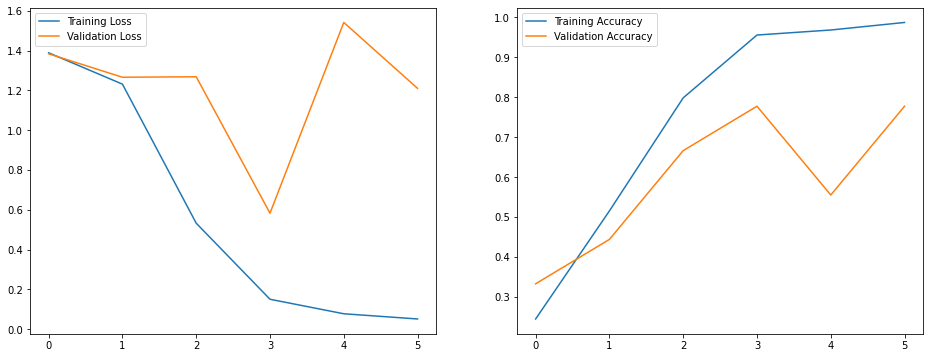

In [67]:

plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [101]:
preds2 = model3.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

In [102]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

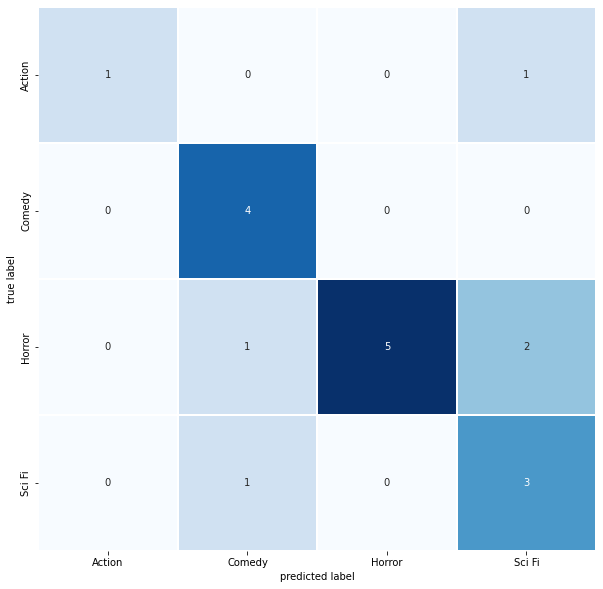

In [103]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [104]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [105]:
preds2.shape

(18, 4)

In [106]:
df2 = pd.DataFrame(preds2[0:15],columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.34%,0.51%,0.07%,0.18%,0.28%,0.14%,0.20%,5.48%,0.07%,97.84%,0.22%,8.92%,0.22%,0.01%,0.33%
Comedy,99.38%,3.51%,1.95%,1.97%,97.46%,0.22%,99.27%,14.05%,0.08%,2.03%,0.56%,40.07%,97.33%,0.47%,99.33%
Horror,0.02%,13.63%,1.87%,2.95%,0.07%,98.64%,0.02%,77.81%,99.15%,0.04%,95.97%,32.21%,0.09%,0.52%,0.03%
Sci Fi,0.26%,82.34%,96.10%,94.90%,2.18%,1.00%,0.51%,2.66%,0.70%,0.09%,3.25%,18.80%,2.36%,99.00%,0.32%


### RNN Model Architecture

In [107]:
model3.summary() ### The winning one

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                      